# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [31]:
# import libraries
import datetime
import seaborn as sns
import time
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

from lightgbm import LGBMClassifier
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, OneHotEncoderEstimator, StringIndexer, VectorAssembler # PCA, IDF, 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col, udf
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import IntegerType, StringType, TimestampType

In [34]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify_mml") \
    .config("spark.jars.packages", "com.microsoft.ml.spark:mmlspark_2.11:1.0.0-rc1") \
    .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
    .getOrCreate()

In [36]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
events = spark.read.json("mini_sparkify_event_data.json")

The userId contains values with an empty string. These entries need to be removed.

In [14]:
# events where a userId is an empty string are not valid, remove these
valid_events = events.where(col("userId") != "")
print("Number of total events: {}; number of valid events {}".format(events.count(), valid_events.count()))
print("Number of users: {}".format(valid_events.select("userId").distinct().count()))

Number of total events: 286500; number of valid events 278154
Number of users: 225


In [15]:
# registration and ts can both be converted to timestamps
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0), TimestampType()) # udf to convert to timestamp/date

In [16]:
valid_events = valid_events.withColumn("log_date", get_date(col("ts"))) # date when the log entry was done

In [21]:
# add a column "churn" to the dataframe indicating that a cancellation was confirmed
find_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [22]:
valid_events = valid_events.withColumn("churn", find_churn(col("page")))

In [40]:
user_length = valid_events.groupBy("userId").agg({"length": "mean"}) \
    .withColumnRenamed("avg(length)", "avg_length")

In [415]:
# some values can be set into relation to a certain time period, e.g. the duration the user is active
# hence we need to create a df with all users and their active time period
# first find the first and last log entry for each user and how much log entries exist per user (all actions)
time_df = valid_events.groupBy(["userId"]) \
    .agg(F.sum("churn").alias("churned"), F.min("log_date").alias("first_log"),
         F.max("log_date").alias("last_log"), F.count("page").alias("log_counts"), F.max("ts").alias("last_ts"))

In [416]:
def get_time_difference(date_1, date_2):
    """TODO"""
    # difference between the dates
    delta = date_2 - date_1
    
    # minimum difference is one 1
    if delta.days == 0:
        return 1
    else:
        return delta.days

# create a udf for this function
get_time_difference_udf = udf(get_time_difference, IntegerType())

time_df = time_df.withColumn("duration", get_time_difference_udf(col("first_log"), col("last_log"))) \
            .drop("first_log", "last_log").withColumnRenamed("churned", "label")

In [420]:
# create a dummy dataframe where each action (About, Thumbs Up, ...) from page is a new column with the number
# how often this action appeared in the data for each user
dummy_df = valid_events.select("userId", "page").groupBy("userId").pivot("page") \
    .count().drop("Cancel", "Cancellation Confirmation")
# fill null values
dummy_df = dummy_df.na.fill(0)

In [421]:
user_level = valid_events.orderBy("log_date", ascending=False).groupBy("userId").agg(F.first("level").alias('valid_level'))

In [422]:
user_gender = valid_events.select(["userId", "gender"]).distinct()

In [429]:
# join user_df (time_df, dummy_df) with user_level and gender_level and user_length
df = time_df.join(dummy_df, on="userId").join(user_level, on="userId") \
    .join(user_gender, on="userId").join(user_length, on="userId")

In [430]:
# calculate the total amount of days the user listened to music
songs_per_date = valid_events.withColumn("date", F.to_date(col("log_date"))).where(col("page") == "NextSong") \
    .groupBy(["userId", "date"]).agg(F.lit(1).alias("played_music"))
songs_per_day = songs_per_date.groupBy("userId").agg(F.sum("played_music").alias("music_days"))
df = df.join(songs_per_day, on="userId")

In [435]:
# divide the actions by the amount of logs or the overall duration of their registration
def divide_columns_by(df, columns, value, appendix):
    """TODO"""
    new_cols = ["userId"]
    for name in columns:
        new_name = name+"_"+appendix
        df = df.withColumn(new_name, col(name) / col(value))
        new_cols.append(new_name)
    
    df_div = df.select(*new_cols)
    return df_div

In [436]:
cols_to_divide = ['music_days', 'About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home',
               'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade',
               'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade']

In [437]:
actions_per_day = divide_columns_by(df, cols_to_divide, "duration", "per_day")
actions_per_log = divide_columns_by(df, cols_to_divide, "log_counts", "per_log")
df = df.join(actions_per_day, on="userId").join(actions_per_log, on="userId")

In [438]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: long (nullable = true)
 |-- log_counts: long (nullable = false)
 |-- last_ts: long (nullable = true)
 |-- duration: integer (nullable = true)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = true)
 |-- valid_level: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- avg_length: double (nullable = true)
 |-- music_days

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [76]:
df = df.drop("userId") # IMPORTANT!
train = df.sampleBy("label", fractions={0: 0.8, 1: 0.5}, seed=42) # randomSplit([0.8, 0.2], seed=42)
test = df.subtract(train) # for balancing

In [66]:
categorical_columns = ["gender", "valid_level"]

indexers = []

for cat in categorical_columns:
    indexers.append(StringIndexer(inputCol = cat, outputCol = "{}_indexed".format(cat)))

encoder = OneHotEncoderEstimator(inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=["{}_encoded".format(indexer.getOutputCol()) for indexer in indexers])

In [156]:
numerical_cols = [col.name for col in df.schema.fields if col.dataType != StringType()]
numerical_cols.remove("label")
numerical_cols

['log_counts',
 'duration',
 'About',
 'Add Friend',
 'Add to Playlist',
 'Downgrade',
 'Error',
 'Help',
 'Home',
 'Logout',
 'NextSong',
 'Roll Advert',
 'Save Settings',
 'Settings',
 'Submit Downgrade',
 'Submit Upgrade',
 'Thumbs Down',
 'Thumbs Up',
 'Upgrade',
 'avg_length']

In [68]:
numeric_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numeric_vectorized")
#Lets scale the data
scaler = StandardScaler(inputCol = "numeric_vectorized", outputCol = "numeric_scaled", withStd = True, withMean = True)


#create final VectorAssembler to push data to ML models
assembler = VectorAssembler(inputCols=["numeric_scaled"] + encoder.getOutputCols(), outputCol="features")

## Random Forst Model

In [404]:
model_rf = RandomForestClassifier(featuresCol="features", labelCol="label")
pipeline_rf = Pipeline(stages= indexers + [encoder, numeric_assembler, scaler, assembler, model_rf])

In [405]:
paramGrid_rf = ParamGridBuilder() \
        .addGrid(model_rf.numTrees, [20,75]) \
        .addGrid(model_rf.maxDepth, [10, 20]) \
        .build() 


crossval_rf = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3) # here you can set parallelism parameter

In [227]:
start_time = time.time()
cvModel_rf = crossval_rf.fit(train)
end_time = time.time()
print("Fitting the model took {} s.".format(round(end_time - start_time,2)))

## Logistic Regression

In [406]:
# Initiate log regression model
model_lr = LogisticRegression()

# Make pipeline for lr
pipeline_lr = Pipeline(stages= indexers + [encoder, numeric_assembler, scaler, assembler, model_lr])

# Grid Search Params
paramGrid_lr = ParamGridBuilder() \
    .addGrid(model_lr.maxIter, [10, 20]) \
    .addGrid(model_lr.elasticNetParam, [0, 0.5]) \
    .addGrid(model_lr.regParam,[0.1, 1]) \
    .build()

crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3) # here you can set parallelism parameter

## GBTC Classifier

In [407]:
# Initiate log regression model
model_gbtc = GBTClassifier()

# Make pipeline for lr
pipeline_gbtc = Pipeline(stages= indexers + [encoder, numeric_assembler, scaler, assembler, model_gbtc])

# Grid Search Params
paramGrid_gbtc = ParamGridBuilder() \
    .addGrid(model_gbtc.maxIter, [10, 12]) \
    .build()

crossval_gbtc = CrossValidator(estimator=pipeline_gbtc,
                          estimatorParamMaps=paramGrid_gbtc,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3) # here you can set parallelism parameter

## LightGBM: either use the one from mmlspark or LGBMClassifier


In [402]:
# Initiate 
# from mmlspark.lightgbm import LightGBMClassifier
#model_lgbm = LGBMClassifier()

# Make pipeline for lr
#pipeline_lgbm = Pipeline(stages= indexers + [encoder, numeric_assembler, scaler, assembler, model_lgbm])

# Grid Search Params
#paramGrid_lgbm = ParamGridBuilder() \
#    .addGrid(model_lgbm.learningRate, [0.1, 0.5]) \
#    .addGrid(model_lgbm.numLeaves, [31, 76]) \
#    .addGrid(model_lgbm.numIterations, [100]) \
#    .addGrid(model_lgbm.objective, ["binary"]) \
#    .build()

#crossval = CrossValidator(estimator=pipeline_lgbm,
#                          estimatorParamMaps=paramGrid_lgbm,
#                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
#                          numFolds=3)

In [410]:
def fit_crossval(crossval, train):
    """TODO"""
    start_time = time.time() # start
    cv_model = corssval.fit(train) # fit
    end_time = time.time() # end
    
    print("Fitting the model took {} s.".format(round(end_time - start_time,2)))
    return cv_model

In [411]:
def evaluate_model(model, train, test, metric = 'f1'):
    """TODO"""
    # init evaluator
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    
    # make predictions
    prediction_result_train = model.transform(train)
    prediction_results_test = model.transform(test)
    
    # calcualte the scores
    score_train = evaluator.evaluate(prediction_result_train)
    score_test = evaluator.evaluate(prediction_result_test)
    print("{} score on training data is {}".format(metric, score_train))
    print("{} score on test data is {}".format(metric, score_test))
    
    # feature importance
    #importance = {}
    #for i in range(len(model.stages[-1].featureImportances)):
    #    importance[features_df.columns[i]] = model.stages[-1].featureImportances[i]
    # 
    #sorted_importance = {k: v for k, v in sorted(importance.items(), key=lambda item: item[1])}
    #print(sorted_importance)
    try:
        print(model.stages[-1].featureImportances)

        # parameters of the model
        print(model.extractParamMap())
    except:
        print("Could not derive feature importance from model.")
        
    return score_train, score_test

# Fit Models and Evaluate

In [412]:
# todo: chache() something here?
crossval_dict = {}
crossval_dict["Random-Forst"] = crossval_rf
crossval_dict["Logistic Regression"] = crossval_lr
crossval_dict["GBTC"] = crossval_gbtc
result_dict = {}
for cv_key in crossval_dict:
    # fit the model
    print("Fitting {} model ...".format(cv_key))
    cv_model = fit_crossval(crossval_dict[cv_key], train)
    # evaluate it
    score_train, score_test = evaluate_model(cv_model.bestModel, train, test)
    print(score_train, score_test)
    result_dict[cv_key] = [score_train, score_test]

print("-------------Result Summary--------------")
print(result_dict)

Fitting Random-Forst model ...


NameError: name 'corssval' is not defined

## Add further features

In [178]:
def divide_columns_by(df, columns, value, appendix, skip=["log_counts", "duration", "avg_length", "label", "valid_level", "gender"]):
    for name in columns:
        if name not in skip:
            df = df.withColumn(name+"_"+appendix, col(name) / col(value))
    to_drop = columns + skip
    df = df.drop(*to_drop)
    return df

In [179]:
df_by_duration = divide_columns_by(df, numerical_cols, "duration", "per_day")

In [180]:
df_by_duration.printSchema()

root
 |-- userId: string (nullable = true)
 |-- About_per_day: double (nullable = true)
 |-- Add Friend_per_day: double (nullable = true)
 |-- Add to Playlist_per_day: double (nullable = true)
 |-- Downgrade_per_day: double (nullable = true)
 |-- Error_per_day: double (nullable = true)
 |-- Help_per_day: double (nullable = true)
 |-- Home_per_day: double (nullable = true)
 |-- Logout_per_day: double (nullable = true)
 |-- NextSong_per_day: double (nullable = true)
 |-- Roll Advert_per_day: double (nullable = true)
 |-- Save Settings_per_day: double (nullable = true)
 |-- Settings_per_day: double (nullable = true)
 |-- Submit Downgrade_per_day: double (nullable = true)
 |-- Submit Upgrade_per_day: double (nullable = true)
 |-- Thumbs Down_per_day: double (nullable = true)
 |-- Thumbs Up_per_day: double (nullable = true)
 |-- Upgrade_per_day: double (nullable = true)



In [162]:
df.cache()

DataFrame[userId: string, label: bigint, log_counts: bigint, duration: int, About: bigint, Add Friend: bigint, Add to Playlist: bigint, Downgrade: bigint, Error: bigint, Help: bigint, Home: bigint, Logout: bigint, NextSong: bigint, Roll Advert: bigint, Save Settings: bigint, Settings: bigint, Submit Downgrade: bigint, Submit Upgrade: bigint, Thumbs Down: bigint, Thumbs Up: bigint, Upgrade: bigint, valid_level: string, gender: string, avg_length: double]

In [181]:
df_by_logs = divide_columns_by(df, numerical_cols, "log_counts", "per_log")

In [182]:
df_per = df.join(df_by_duration, on="userId").join(df_by_logs, on="userId")

In [183]:
df_per.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: long (nullable = true)
 |-- log_counts: long (nullable = false)
 |-- duration: integer (nullable = true)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = true)
 |-- valid_level: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- avg_length: double (nullable = true)
 |-- About_per_day: double (nullable = true)
 |-- Ad

## Last log

In [211]:
time_df = time_df.withColumn("duration", get_time_difference_udf(col("first_log"), col("last_log"))) \
            .withColumnRenamed("churned", "label")

In [214]:
df_per = df_per.join(time_df.select("userId", "last_log"), on="userId")

In [246]:
last_song = valid_events.where(col("page") == "NextSong").select("userId", "log_date") \
    .groupBy(["userId"]).agg(F.max("log_date").alias("last_song"))

In [247]:
df_per = df_per.join(last_song, on="userId")

## Number of Sessions

In [314]:
user_sessions = valid_events.groupBy(["userId"]).agg(F.countDistinct("sessionId").alias("number_sessions"))

In [315]:
df_per = df_per.join(user_sessions, on="userId")
df_per = df_per.withColumn("sessions_per_day", col("number_sessions") / col("duration"))

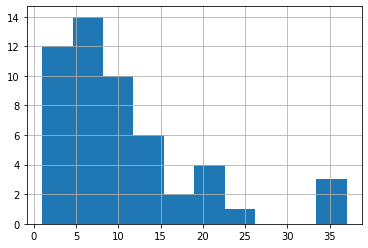

In [377]:
pd_df[pd_df["label"] == 1]["number_sessions"].hist()

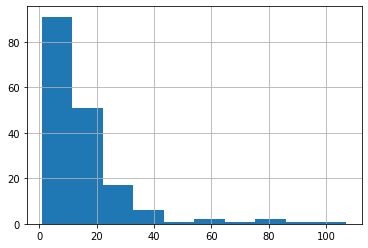

In [378]:
pd_df[pd_df["label"] == 0]["number_sessions"].hist()

## Ratio of Music Days

In [348]:
songs_per_day = valid_events.withColumn("date", F.to_date(col("log_date"))).where(col("page") == "NextSong") \
    .groupBy(["userId", "date"]).agg(F.lit(1).alias("played_music"))# ("page").alias("songs"))
songs_per_day.show()
# where(col("userId") == 7).select("page", "itemInSession", "length", "log_date", "sessionId").show(200)

+------+----------+------------+
|userId|      date|played_music|
+------+----------+------------+
|   118|2018-10-02|           1|
|    52|2018-10-29|           1|
|     9|2018-11-01|           1|
|   110|2018-11-05|           1|
|    29|2018-11-06|           1|
|   148|2018-11-08|           1|
|   140|2018-11-14|           1|
|    75|2018-11-14|           1|
|    39|2018-11-17|           1|
|    61|2018-11-21|           1|
|    39|2018-11-25|           1|
|200004|2018-10-06|           1|
|200012|2018-11-28|           1|
|300021|2018-10-10|           1|
|300004|2018-10-17|           1|
|300016|2018-11-05|           1|
|    46|2018-10-02|           1|
|   142|2018-10-05|           1|
|    20|2018-10-10|           1|
|    39|2018-10-13|           1|
+------+----------+------------+
only showing top 20 rows



In [349]:
songs_per_day = songs_per_day.groupBy("userId").agg(F.sum("played_music").alias("music_days"))

+------+----------+
|userId|music_days|
+------+----------+
|200002|         8|
|100010|         7|
|   125|         1|
|    51|        14|
|   124|        35|
|     7|         7|
|    15|        18|
|    54|        30|
|   155|         8|
|   132|        22|
|100014|         6|
|   154|         3|
|    11|        16|
|   101|        13|
|300017|        47|
|   138|        19|
|    29|        29|
|100021|         5|
|    69|        12|
|    42|        43|
+------+----------+
only showing top 20 rows



In [350]:
df_per = df_per.join(songs_per_day, on="userId")
df_per = df_per.withColumn("ratio_music_days", col("music_days") / col("duration"))

## Thumbs up per Song

In [379]:
df_per = df_per.withColumn("like_ratio", col("Thumbs Up") / col("NextSong"))

## Feature Selection for numerical variables --> move to exploration
https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2 thanks

In [4]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [440]:
pd_df = df.toPandas()

In [482]:
pd_df.to_csv("feature_df.csv")

In [380]:
# pd_df = df_per.toPandas()

In [381]:
# pd_df["last_log"] = pd_df["last_log"].values.astype(np.int64) // 10 ** 9
# pd_df["last_song"] = pd_df["last_song"].values.astype(np.int64) // 10 ** 9

In [447]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [448]:
X = pd_df.drop(["label"], axis=1).select_dtypes(include=["int64", "int32", "float64", "datetime64[ns]"])
y = pd_df["label"]

In [471]:
num_features = 25
cor_support, cor_features = cor_selector(X, y, num_features)

In [472]:
def select_from_model(X, y, num_features):
    """TODO"""
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_features)
    embeded_rf_selector.fit(X, y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    return embeded_rf_support, embeded_rf_feature

In [473]:
embeded_rf_support, embeded_rf_feature = select_from_model(X, y, num_features)

13 selected features


In [474]:
def select_by_rfe(X, y, num_features):
    X_norm=(X-X.mean())/X.std()
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_features, step=10, verbose=5)
    rfe_selector.fit(X_norm, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    return rfe_support, rfe_feature

In [475]:
rfe_support, rfe_feature = select_by_rfe(X, y, num_features)

Fitting estimator with 58 features.
Fitting estimator with 48 features.
Fitting estimator with 38 features.
Fitting estimator with 28 features.
25 selected features


C:\Users\FRANZK1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\FRANZK1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\FRANZK1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\FRANZK1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\FRANZK1\AppData\Local\Continuum\anaconda3\lib\site-packages\skl

In [476]:
def select_from_model_lr(X, y, num_features):
    X_norm=(X-X.mean())/X.std()
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"), max_features=num_features)
    embeded_lr_selector.fit(X_norm, y)

    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    return embeded_lr_support, embeded_lr_feature

In [477]:
embeded_lr_support, embeded_lr_feature = select_from_model_lr(X, y, num_features)

25 selected features


C:\Users\FRANZK1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [478]:
def select_by_lgbm(X, y, num_features):    
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_features)
    embeded_lgb_selector.fit(X, y)

    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    return embeded_lgb_support, embeded_lgb_feature

In [479]:
embeded_lgb_support, embeded_lgb_feature = select_by_lgbm(X, y, num_features)

25 selected features


In [480]:
feature_name = X.columns
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)

In [481]:
feature_selection_df.head(len(feature_name))

,Feature,Pearson,RFE,Logistics,Random Forest,LightGBM,Total
1,last_ts,True,True,True,True,True,5
2,duration,True,True,True,True,True,5
21,music_days,True,True,True,False,True,4
55,Thumbs Down_per_log,True,True,True,True,False,4
36,Submit Upgrade_per_day,True,True,True,True,False,4
49,NextSong_per_log,True,True,True,True,False,4
24,Add Friend_per_day,True,True,True,False,True,4
3,About,True,True,True,False,True,4
22,music_days_per_day,True,False,False,True,True,3
37,Thumbs Down_per_day,True,False,True,True,False,3


In [13]:
feature_selection_df.to_csv("feature_selection_df.csv")

NameError: name 'feature_selection_df' is not defined

,Feature,Pearson,RFE,Logistics,Random Forest,LightGBM,Total
0,last_ts,True,True,True,True,True,5
1,duration,True,True,True,True,True,5
2,music_days,True,True,True,False,True,4
3,Thumbs Down_per_log,True,True,True,True,False,4
4,Submit Upgrade_per_day,True,True,True,True,False,4
5,NextSong_per_log,True,True,True,True,False,4
6,Add Friend_per_day,True,True,True,False,True,4
7,About,True,True,True,False,True,4
8,music_days_per_day,True,False,False,True,True,3
9,Thumbs Down_per_day,True,False,True,True,False,3


['last_ts', 'duration', 'music_days', 'Thumbs Down', 'Submit Upgrade', 'NextSong', 'Add Friend', 'About', 'Submit Downgrade', 'Roll Advert', 'Home', 'Help', 'Downgrade', 'Add to Playlist', 'log_counts', 'avg_length', 'Upgrade', 'Thumbs Up', 'Settings', 'Save Settings', 'Logout', 'Error']
['last_ts', 'duration', 'music_days', 'Thumbs Down_per_log', 'Submit Upgrade_per_day', 'NextSong_per_log', 'Add Friend_per_day', 'About', 'Submit Downgrade', 'Roll Advert', 'Home_per_day', 'Help_per_day', 'Downgrade', 'Add to Playlist', 'log_counts', 'avg_length', 'Upgrade_per_log', 'Thumbs Up_per_day', 'Settings_per_day', 'Save Settings_per_day', 'Logout_per_log', 'Error']


In [26]:
len(important_features)

37

In [27]:
len(final_features)

22